# Bankruptcy Prediction Using Random Forest and XGBoost

The aim is to accurately forecast whether companies will face bankruptcy in the future.

In [1]:
# --------------------------------------------------------------
# IMPORTANT NOTE:
# --------------------------------------------------------------
# This code is designed to run on a GPU environment.
# Please make sure to change the runtime to GPU in Colab.
# --------------------------------------------------------------

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, KFold
from collections import defaultdict

## The Data

Sourced from the Taiwan Economic Journal, the dataset adheres to Taiwan Stock Exchange's corporate regulations for defining company bankruptcy. It contains 95 features.

In [3]:
data = pd.read_csv("data.csv")

In [4]:
print("Number of features: ", len(data.columns) - 1)
print("Number of rows: ", len(data))

Number of features:  95
Number of rows:  6819


In [5]:
# Check if there are some duplicates rows
print("Number of duplicated rows: ", data.duplicated().sum())

# Check if there are some missing values or null values
print(data.isnull().sum())

Number of duplicated rows:  0
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64


### The distribution of values for each feature

In [6]:
print(data.describe())

         Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                          

### The correlation of the input features with the target feature

In [7]:
corr = data.corr().sort_values(by='Bankrupt?', ascending=False)
print(corr['Bankrupt?'])

Bankrupt?                                                   1.000000
 Debt ratio %                                               0.250161
 Current Liability to Assets                                0.194494
 Borrowing dependency                                       0.176543
 Current Liability to Current Assets                        0.171306
                                                              ...   
 ROA(C) before interest and depreciation before interest   -0.260807
 ROA(B) before interest and depreciation after tax         -0.273051
 ROA(A) before interest and % after tax                    -0.282941
 Net Income to Total Assets                                -0.315457
 Net Income Flag                                                 NaN
Name: Bankrupt?, Length: 96, dtype: float64


### The shape of the data

In [8]:
labelsCount = data['Bankrupt?'].value_counts()
print("Percentage label 0: ", "{:.2f}".format((labelsCount[0] * 100) /
(labelsCount[0] + labelsCount[1])), "%")
print("Percentage label 1: ", "{:.2f}".format((labelsCount[1] * 100) /
(labelsCount[0] + labelsCount[1])), "%")
print(labelsCount)

Percentage label 0:  96.77 %
Percentage label 1:  3.23 %
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


The dataset is highly unbalanced.

### Pre-processing

Divide the dataset into two dataframes, one for the input features X and one for the target feature y.

Divide into 70% training set and 30% test set.

In [9]:
# Drop the feature with NaN correlation
X = data.drop(columns=['Bankrupt?', ' Net Income Flag'])
y = data['Bankrupt?']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Input feature after feature scaling: \n")
print(pd.DataFrame(X_train).describe())

Input feature after feature scaling: 



                 0             1             2             3             4   \
count  4.773000e+03  4.773000e+03  4.773000e+03  4.773000e+03  4.773000e+03   
mean   5.184297e-16  6.699020e-18  5.366659e-16  2.459843e-15 -3.530570e-15   
std    1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00   
min   -8.219154e+00 -8.343064e+00 -8.894932e+00 -3.586480e+01 -3.589848e+01   
25%   -4.750930e-01 -3.527601e-01 -4.309976e-01 -4.403760e-01 -4.395098e-01   
50%   -3.725781e-02  1.761871e-02 -1.956832e-02 -1.121635e-01 -1.114066e-01   
75%    4.971703e-01  4.628963e-01  4.906384e-01  3.486945e-01  3.473420e-01   
max    8.021918e+00  6.650691e+00  7.149093e+00  2.312758e+01  2.315072e+01   

                 5             6             7             8             9   \
count  4.773000e+03  4.773000e+03  4.773000e+03  4.773000e+03  4.773000e+03   
mean   1.873046e-14  9.657754e-15  1.935272e-17  1.565338e-15 -2.849317e-15   
std    1.000105e+00  1.000105e+00  1.000105e+00  1.

### Feature selection
PCA

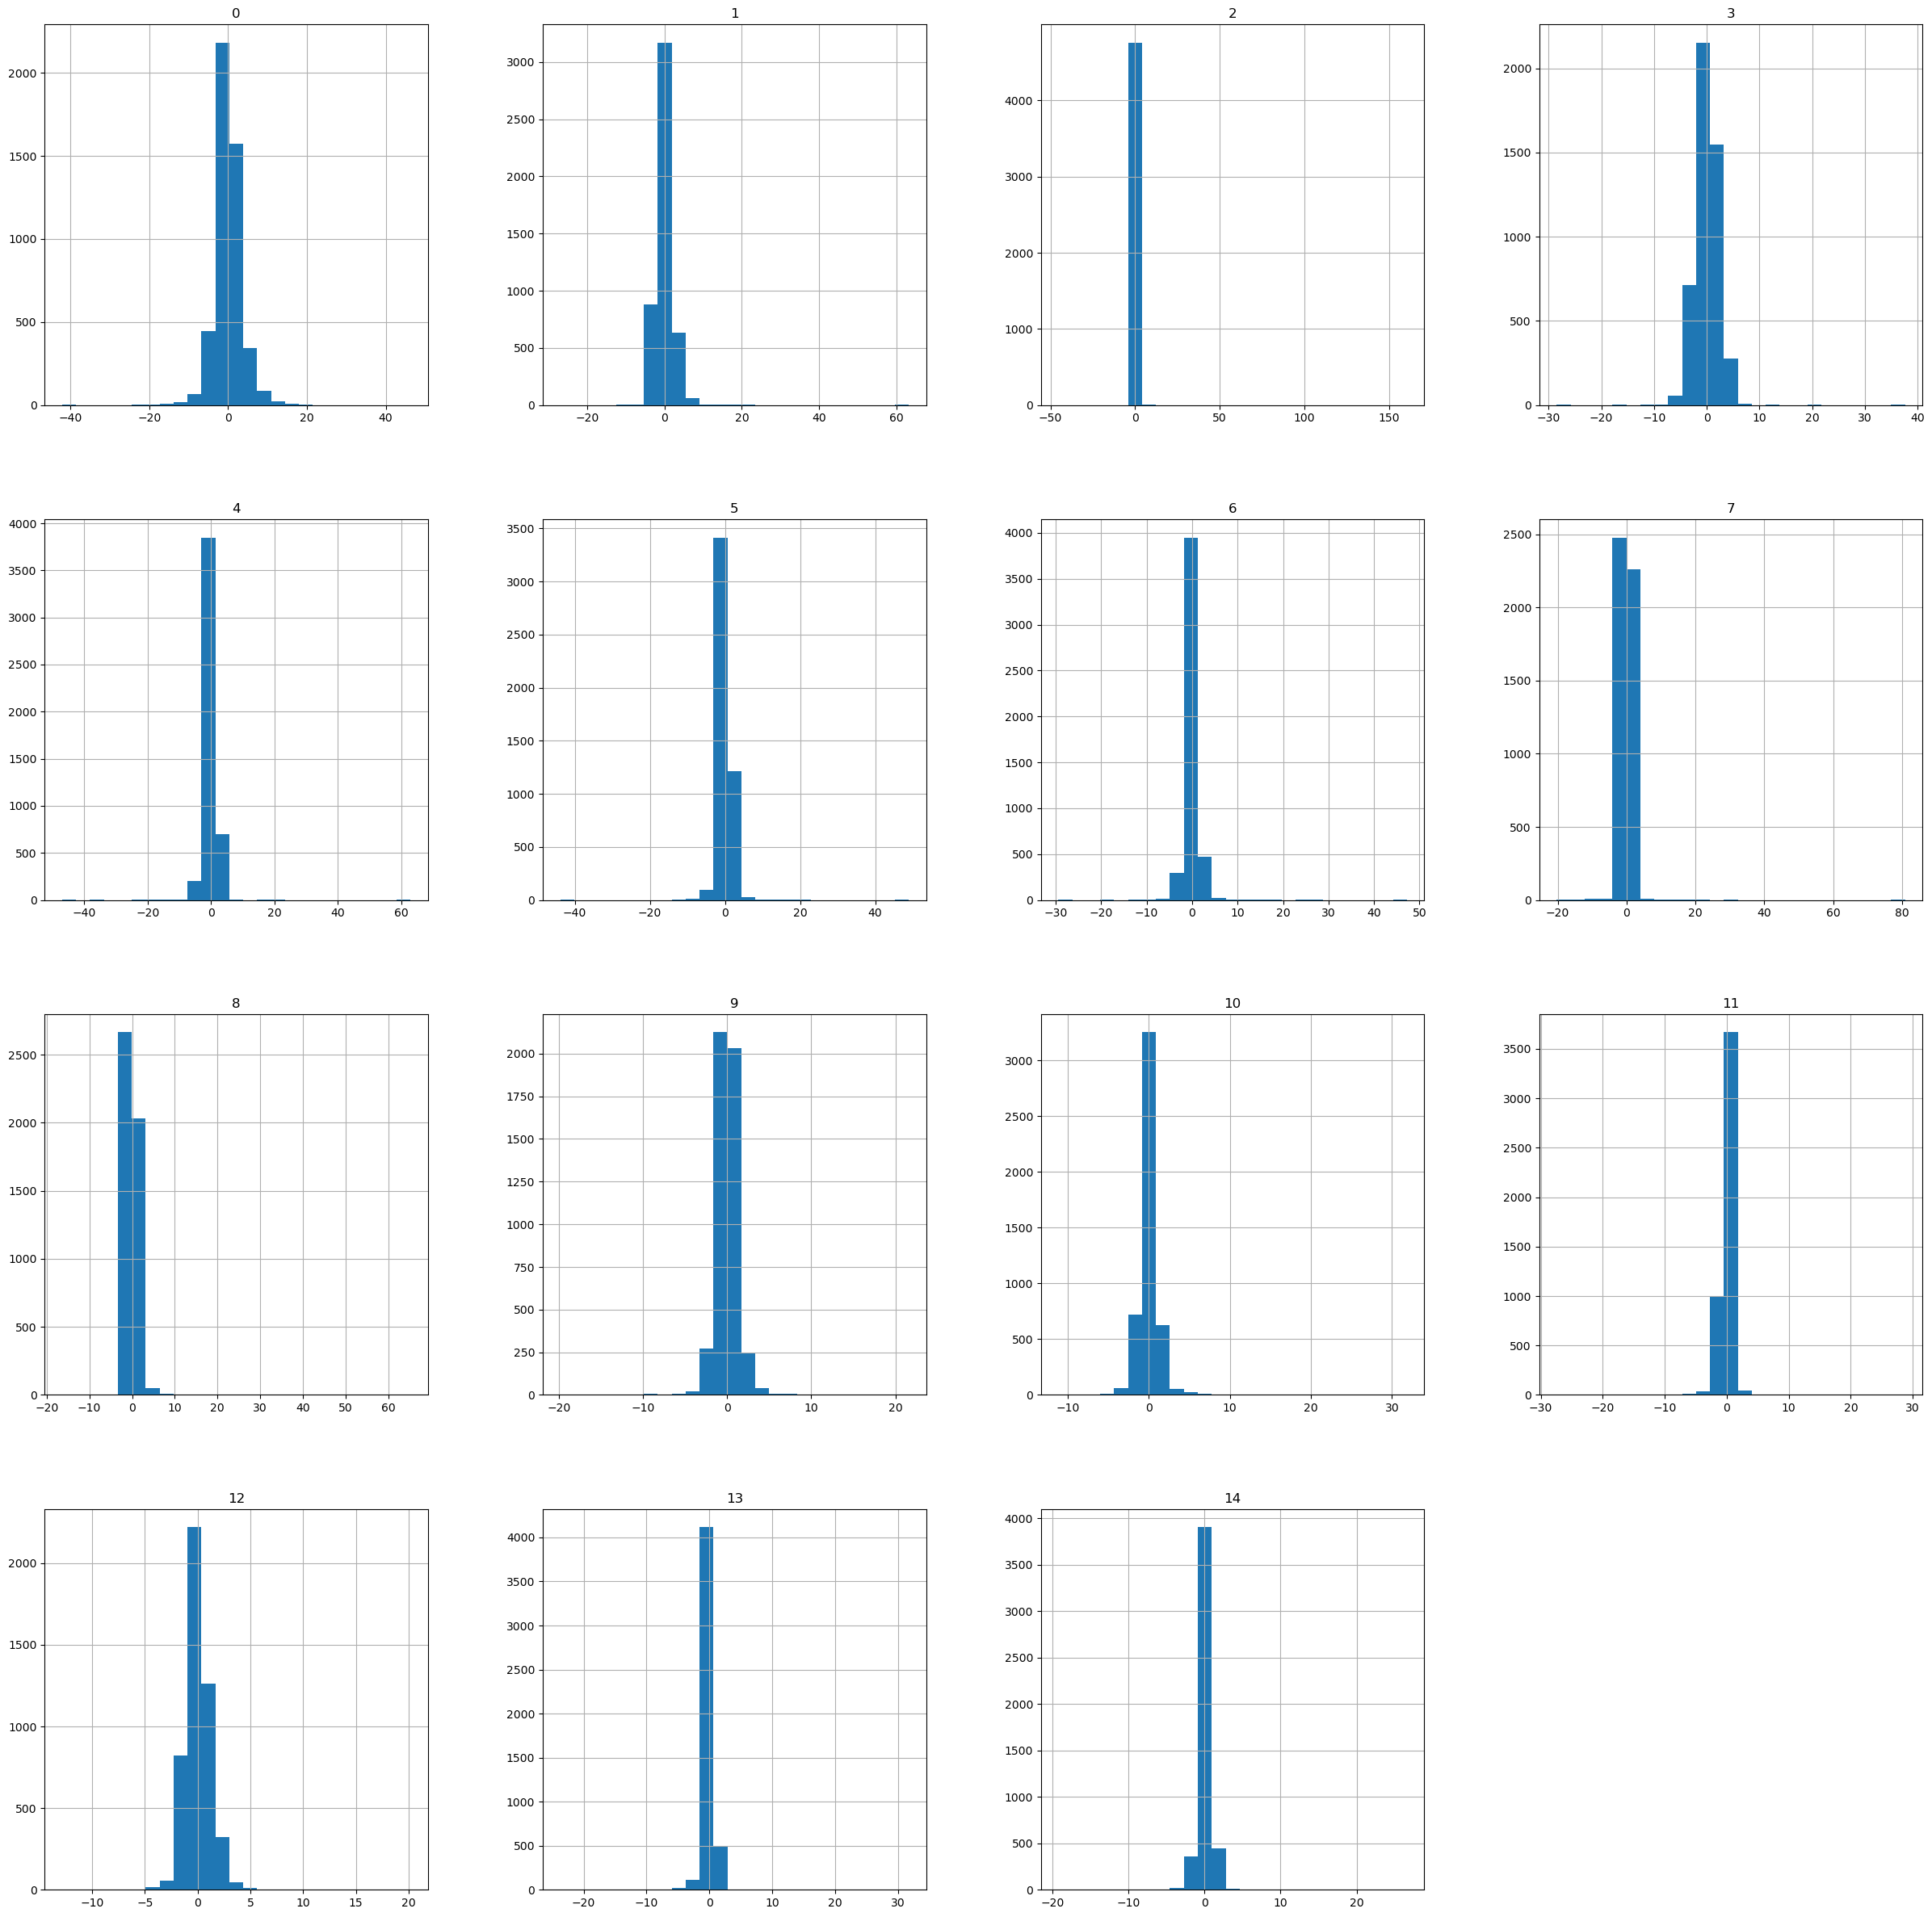

In [10]:
pca = PCA(n_components=15)
pca.fit(X_train)
X_train_reduced = pd.DataFrame(pca.transform(X_train))
X_test_reduced = pd.DataFrame(pca.transform(X_test))

pd.DataFrame(X_train_reduced).hist(figsize=(30, 30), bins=25)
plt.show()

## Modelling

To systematically compare the performance of different machine learning models, we implemented a function `evaluate_models` that conducts k-fold cross-validation for each model on the dataset and calculates their recall scores. We compared two models in this experiment:

1. Random Forest
2. XGBoost

**Methodology**
- **Data Splitting**: We used k-fold cross-validation with 10 folds to assess the performance of each model. The dataset was split into training and validation sets for each fold.
- **Metric of Evaluation**: The main metric used for evaluation is the Recall score, which is particularly important for imbalanced classes.
- **Model Fitting and Evaluation**: For each fold, each model was trained on the training set and evaluated on the validation set. The recall score for each model was computed for every fold.

**Function Details**
1. **`evaluate_models`**: Conducts k-fold cross-validation and computes the recall scores for each model. The average recall score over all folds is used for model comparison.

2. **`plot_recall_scores`**: Plots the average recall scores to provide a visual comparison between models.

In [11]:
MODEL_NAMES = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

def evaluate_models(X, y, num_splits=10):
    """
    Evaluate and compare models based on recall score.
    
    Parameters:
    - X: Features dataset
    - y: Target dataset
    - num_splits: Number of splits for k-fold validation
    
    Returns:
    - None
    """
    print("=" * 10, " Evaluating Models ", "=" * 10)
    
    # Initialize recall scores dictionary
    recall_scores = defaultdict(float)
    
    # Perform k-fold cross-validation
    kfold = KFold(n_splits=num_splits, shuffle=False)
    
    for idx, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        for model_name, model in MODEL_NAMES.items():
            model.fit(X_train, y_train.values.ravel())
            score = recall_score(y_val, model.predict(X_val))
            recall_scores[model_name] += score
            
            print(f"Iteration {idx+1} - Recall for {model_name}: {score:.2f}")
            
    print("-" * 50)
    
    # Calculate average recall scores
    avg_recall = {k: v / num_splits for k, v in recall_scores.items()}
    
    # Identify and print the best model
    best_model = max(avg_recall, key=avg_recall.get)
    print(f"The best model is {best_model} with an average recall of {avg_recall[best_model]:.2f}")
    
    # Plot average recall scores
    plot_recall_scores(avg_recall)

def plot_recall_scores(recall_scores):
    """
    Plot average recall scores for each model.
    
    Parameters:
    - recall_scores: Dictionary containing average recall scores
    
    Returns:
    - None
    """
    colors = ['green' if model == max(recall_scores, key=recall_scores.get) else 'blue' for model in recall_scores]
    plt.bar(recall_scores.keys(), recall_scores.values(), color=colors)
    plt.title("Average Recall Scores")
    plt.xlabel("Models")
    plt.ylabel("Recall")
    plt.show()

==========  Evaluating Models  ==========
Iteration 1 - Recall for Random Forest: 0.00
Iteration 1 - Recall for XGBoost: 0.11
Iteration 2 - Recall for Random Forest: 0.07
Iteration 2 - Recall for XGBoost: 0.14
Iteration 3 - Recall for Random Forest: 0.20
Iteration 3 - Recall for XGBoost: 0.20
Iteration 4 - Recall for Random Forest: 0.08
Iteration 4 - Recall for XGBoost: 0.17
Iteration 5 - Recall for Random Forest: 0.09
Iteration 5 - Recall for XGBoost: 0.09
Iteration 6 - Recall for Random Forest: 0.06
Iteration 6 - Recall for XGBoost: 0.06
Iteration 7 - Recall for Random Forest: 0.11
Iteration 7 - Recall for XGBoost: 0.17
Iteration 8 - Recall for Random Forest: 0.04
Iteration 8 - Recall for XGBoost: 0.28
Iteration 9 - Recall for Random Forest: 0.00
Iteration 9 - Recall for XGBoost: 0.00
Iteration 10 - Recall for Random Forest: 0.00
Iteration 10 - Recall for XGBoost: 0.14
--------------------------------------------------
The best model is XGBoost with an average recall of 0.14


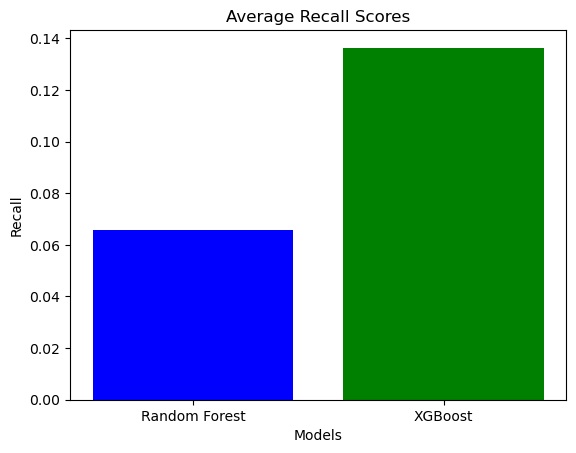

In [12]:
evaluate_models(X_train_reduced, y_train)

The k-fold cross-validation results show that XGBoost is the more appropriate model for our specific use case, based on the Recall metric. However, further tuning may be required to improve the model's performance.

## Fine Tuning

**Hyperparameter Optimization Strategy**
To optimize the performance of our XGBoost model, we employed a two-stage strategy for hyperparameter tuning:

1. Random Search: We initialized an XGBoost classifier and set up a Random Search with the above hyperparameter space. The search was executed and the best set of hyperparameters.
2. Grid Search: Post Random Search, we conducted a Grid Search specifically focusing on the `reg_alpha` parameter to fine-tune its optimal value.

**Hyperparameter Space**
The initial hyperparameter space considered for Random Search was as follows:

- **n_estimators**: Range from 100 to 500 with a step of 100
- **max_depth**: Range from 3 to 10
- **min_child_weight**: Range from 1 to 6 with a step of 2
- **gamma**: Values from 0.0 to 0.4 in steps of 0.1
- **subsample**: Values from 0.6 to 0.9 in steps of 0.1
- **colsample_bytree**: Values from 0.6 to 0.9 in steps of 0.1
- **scale_pos_weight**: Fixed at 30 to account for class imbalance
- **learning_rate**: Fixed at 0.01

**Methodology**
We used 10-fold cross-validation for both Random Search and Grid Search. The scoring metric used was Recall, as we are particularly interested in the True Positive Rate.

In [13]:
space = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)],
    'scale_pos_weight': [30],  # because of high class imbalance
    'learning_rate': [0.01]
}

def epoch(i, reg):
    """
    Used to return string with epoch and reg_alpha.
    :param i: is the epoch
    :param reg: is the value of reg_alpha
    :return: string
    """

    return str(i) + " (n=" + str(reg) + ")"

def random_search_all_param(X_train, y_train):
    """
    It deals with choosing the best parameters for the model.
    Use the Random search.
    :param X_train: training dataset of feature X
    :param y_train: training dataset of target feature y
    :return: dictionary of the best parameters of the model
    """

    print("=" * 10, " Random Search ", "=" * 10)

    model = XGBClassifier(tree_method = 'gpu_hist', gpu_id=0)
    num_split = 10
    cv = KFold(n_splits=num_split, random_state=None, shuffle=False)
    # RandomSearch
    search = RandomizedSearchCV(model, space, random_state=0, scoring='recall', n_jobs=-1, cv=cv, return_train_score=True)
    result = search.fit(X_train, y_train)

    print("Best Score: ", result.best_score_)
    print("Best Hyperparameters: ", result.best_params_)

    print(" ------------------------------------------------------- ")

    cv_result = pd.DataFrame(result.cv_results_)
    print(cv_result)

    # Plot accuracy during training and validation
    epochs = [i for i in range(0, len(cv_result['mean_train_score']))]
    plt.plot(epochs, cv_result['mean_train_score'], 'g', label='Training score')
    plt.plot(epochs, cv_result['mean_test_score'], 'b', label='Validation score')
    plt.title('Training and Validation score')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(" ------------------------------------------------------- ")

    return result.best_params_


def number_estimators(X_train, y_train, best_param):
    """
    It deals with choosing the best number of estimators around a range of estimators for the model.
    Use the Grind search.
    :param X_train: training dataset of feature X
    :param y_train: training dataset of target feature y
    :param best_param: dictionary of the best parameters of the model selected by RandomSearch
    :return: dictionary of the best parameters of the model
    """

    print("=" * 10, " Grind Search ", "=" * 10)

    model = XGBClassifier(tree_method = 'gpu_hist', gpu_id=0)
    model.set_params(**best_param)
    number_split = 10
    cv = KFold(n_splits=number_split, random_state=None, shuffle=False)

    space = dict()
    space['reg_alpha'] = [1e-5, 1e-2, 0.1, 1, 100, 200]
    # GrindSearch
    search = GridSearchCV(model, space, n_jobs=-1, cv=cv, scoring='recall', return_train_score=True)
    result = search.fit(X_train, y_train)

    print("Best Score: ", result.best_score_)
    print("Best Hyperparameters: ", result.best_params_)

    print(" ------------------------------------------------------- ")

    cv_result = pd.DataFrame(result.cv_results_)
    print(cv_result)

    # Plot accuracy during training and validation
    epochs = [epoch(i,  cv_result['param_reg_alpha'][i]) for i in range(0, len(cv_result['mean_train_score']))]
    plt.plot(epochs, cv_result['mean_train_score'], 'g', label='Training accuracy')
    plt.plot(epochs, cv_result['mean_test_score'], 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return result.best_params_['reg_alpha']


def hyperparameter_optimization(X_train, y_train):
    """
    The function is concerned with finding the best parameters for the model.
    :param X_train: training dataset of feature X
    :param y_train: training dataset of target feature y
    :return: dictionary of the best parameters of the model
    """

    best_param = random_search_all_param(X_train, y_train)

    best_param['reg_alpha'] = number_estimators(X_train, y_train, best_param)

    return best_param

==========  Random Search  ==========
Best Score:  0.7675911865911866
Best Hyperparameters:  {'subsample': 0.7, 'scale_pos_weight': 30, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
 ------------------------------------------------------- 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      23.137759      0.343024         0.010820        0.001269   
1      40.580646      0.180296         0.013807        0.002105   
2      22.034488      0.092024         0.011326        0.002261   
3      10.257927      0.043720         0.009391        0.000787   
4       9.344749      0.078433         0.009437        0.001295   
5      23.522388      0.169296         0.010082        0.000890   
6       7.463358      0.042089         0.008990        0.000683   
7      15.778202      0.110209         0.007500        0.000646   
8       8.974541      1.417969         0.006417        0.003694   
9       5.5647

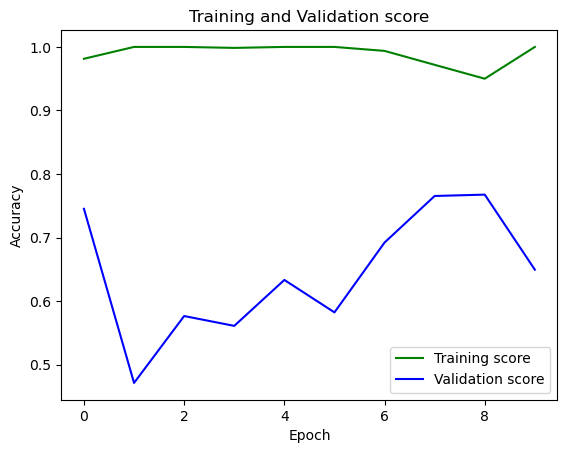

 ------------------------------------------------------- 
==========  Grind Search  ==========
Best Score:  0.8105652403152404
Best Hyperparameters:  {'reg_alpha': 200}
 ------------------------------------------------------- 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       9.986931      0.056548         0.006308        0.001089   
1      10.004962      0.038741         0.006606        0.000917   
2      10.014296      0.034889         0.006854        0.000579   
3      10.000906      0.052691         0.007442        0.001430   
4       9.051929      1.979976         0.005903        0.000840   
5       5.061500      0.023197         0.003241        0.001000   

  param_reg_alpha                params  split0_test_score  split1_test_score  \
0         0.00001  {'reg_alpha': 1e-05}           0.888889           0.714286   
1            0.01   {'reg_alpha': 0.01}           0.888889           0.714286   
2             0.1    {'reg_alpha': 0.1}           0.888889  

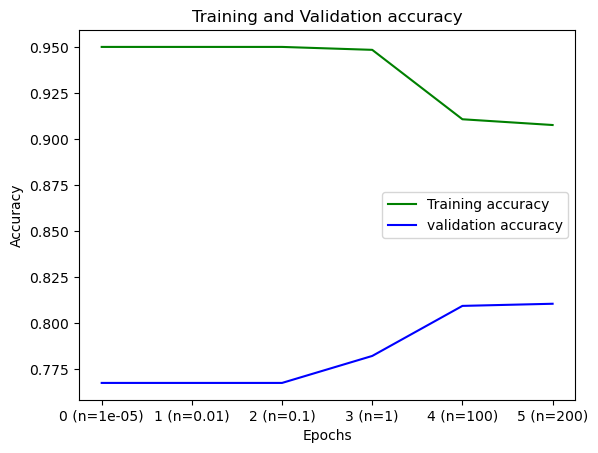

In [14]:
best_params = hyperparameter_optimization(X_train, y_train)

### Testing

In [16]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params, apply_smote=False):
    """
    Train and evaluate an XGBoost model. Optionally use SMOTE for handling class imbalance.
    
    Parameters:
    - X_train: DataFrame, training feature set
    - X_test: DataFrame, test feature set
    - y_train: Series, training labels
    - y_test: Series, test labels
    - best_params: dict, best parameters for the model
    - apply_smote: bool, whether to apply SMOTE or not
    
    Returns:
    - None, prints evaluation metrics and plots relevant graphs
    """
    
    # Display header based on whether SMOTE is applied
    print("=" * 20, " XGBoost with SMOTE " if apply_smote else " XGBoost", "=" * 20)
    
    # Apply SMOTE if required
    if apply_smote:
        smote = SMOTE(sampling_strategy=0.3, k_neighbors=3, random_state=1)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Initialize and train model
    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive outcome
    
    # Display metrics
    print(f"\nAccuracy: {'{:.2f}'.format(accuracy_score(y_test, y_pred) * 100)}%")
    print(f"Recall score: {'{:.2f}'.format(recall_score(y_test, y_pred) * 100)}%")
    print(f"Train score: {model.score(X_train, y_train)}")
    print(f"Test score: {model.score(X_test, y_test)}")
    print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['class 0', 'class 1']).plot()
    plt.show()
    
    # Display feature importance
    plot_importance(model)
    plt.show()
    
    # Display ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {'{:.2f}'.format(auc * 100)}%")
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='XGBoost Model').plot()
    plt.show()

====================  XGBoost ====================



Accuracy: 82.16%
Recall score: 93.59%
Train score: 0.8326000419023675
Test score: 0.821603128054741
              precision    recall  f1-score   support

     class 0       1.00      0.82      0.90      1968
     class 1       0.17      0.94      0.29        78

    accuracy                           0.82      2046
   macro avg       0.58      0.88      0.59      2046
weighted avg       0.97      0.82      0.87      2046



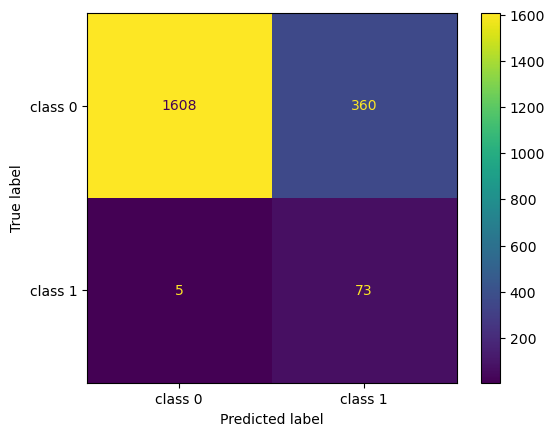

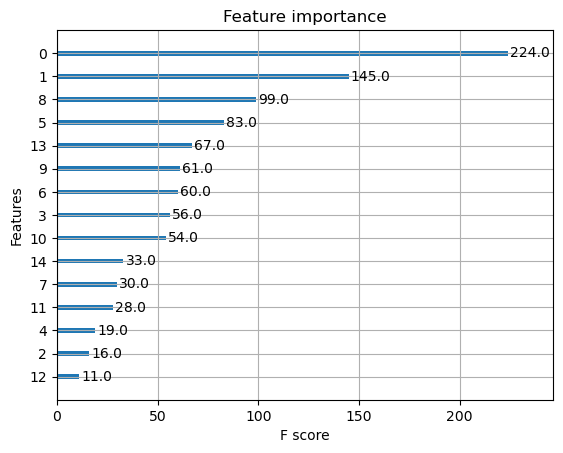

AUC: 92.23%


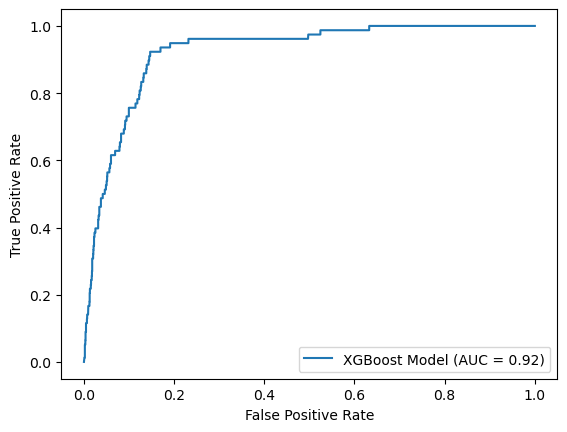

====================  XGBoost with SMOTE  ====================

Accuracy: 45.65%
Recall score: 98.72%
Train score: 0.5729235880398671
Test score: 0.45650048875855326
              precision    recall  f1-score   support

     class 0       1.00      0.44      0.61      1968
     class 1       0.06      0.99      0.12        78

    accuracy                           0.46      2046
   macro avg       0.53      0.71      0.36      2046
weighted avg       0.96      0.46      0.59      2046



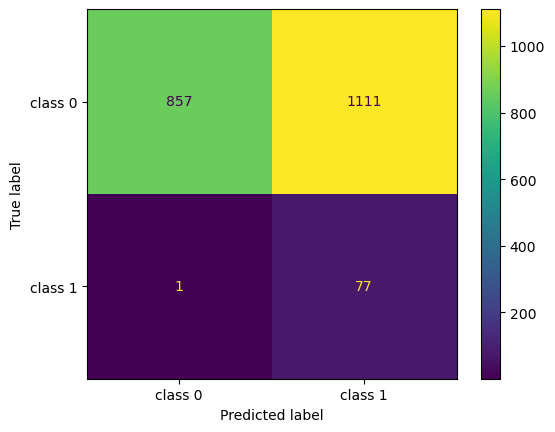

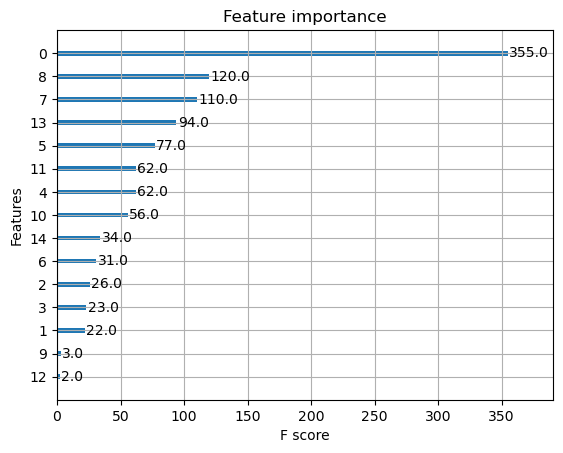

AUC: 89.08%


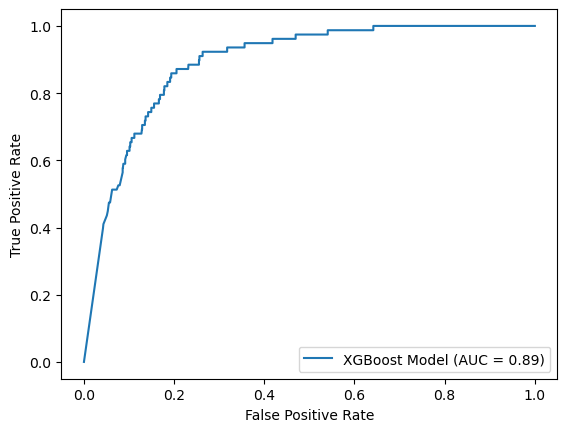

In [17]:
train_and_evaluate_model(X_train_reduced, X_test_reduced, y_train, y_test, best_params, apply_smote=False)
train_and_evaluate_model(X_train_reduced, X_test_reduced, y_train, y_test, best_params, apply_smote=True)